The repository contains the following packages: config, data, models

__1-__ The __config__ package contains configs of the models and also settings of the project.


__2-__ The __data__ package stores and loads the data needed for the models. It has datasets and data_loaders sub-packages.
The datasets sub-package stores raw data samples; one of our used datasets is CAVE which you can find its full data here: https://www1.cs.columbia.edu/CAVE/databases/multispectral/

In data_loader sub-package, we prepare data samples needed for the models. In reformat_cave_data.py file, we change the CAVE data format to use them for our models. Also, in simulate_data.py we select some random patches from both RGB and HS images to train our models and then simulate functionality of the spectrophotometer.


__3-__ The __models__ package contains our implemented models. At regression.py file, we have implemented a regression model to reconstruct HS images from the corresponding RGB images.


We evaluate our models by using RMSE and delta_e 2000.

At the first we should load the data and select some random patches to train the model. The number of patches is:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from config import PATCHES_NUM

patches_num = PATCHES_NUM
print(patches_num)

200


At load_data we have normalized the hyperspectrul image.

In [3]:
import os

from config import PATCHES_SIZE, DATASETS_DIR
from data.data_loader.simulate_data import load_data, random_patches


folder_path = os.path.join(DATASETS_DIR, 'CAVE', 'balloons_ms')

rgb_img, hs_img = load_data(folder_path)
rgb_patches, hs_patches, patches = random_patches(rgb_img, hs_img, patches_num, PATCHES_SIZE)

Now it's time to simulate functionality of the spectrophotometer.

In [4]:
from data.data_loader.simulate_data import simulate_spectrophotometer

avg_rgb_patches = simulate_spectrophotometer(rgb_patches)
avg_hs_patches = simulate_spectrophotometer(hs_patches)

Then we should split the data to test and train sets with the TRAIN_RATIO of:

In [5]:
from config import TRAIN_RATIO

print(TRAIN_RATIO)

0.8


In [6]:
train_samples = int(TRAIN_RATIO * patches_num)
train_rgb, test_rgb = avg_rgb_patches[:train_samples], avg_rgb_patches[train_samples:]
train_hs, test_hs = avg_hs_patches[:train_samples], avg_hs_patches[train_samples:]

Finally we train the regresson model.

In [7]:
from models.regression import Regression

regresstion = Regression(train_rgb, train_hs)
regresstion.train()
predictions = regresstion.model.predict(test_rgb)

The RMSE score is as follows.

In [8]:
from main import get_rmse, get_delta_e_2000

print('rmse is: ', get_rmse(test_hs, predictions), '\ndelta e is: ', get_delta_e_2000(test_hs, predictions))

rmse is:  3.856693871156148 
delta e is:  29.101491641289492


In [9]:
import seaborn as sns
from main import run
import numpy as np

def multi_run(method='rgb'):
    rmses = []
    delta_es = []
    for i in range(100):
        rmse, delta_e = run(patches_num)
        rmses.append(rmse)
        delta_es.append(delta_e)
    return rmses, delta_es

rgb_rmses, rgb_delta_es = multi_run()
sns.set(color_codes=True)
print('rmse mean is: ', np.mean(rgb_rmses), '\ndelta e mean is: ', np.mean(rgb_delta_es))

rmse mean is:  4.993698475728996 
delta e mean is:  27.03465531086455


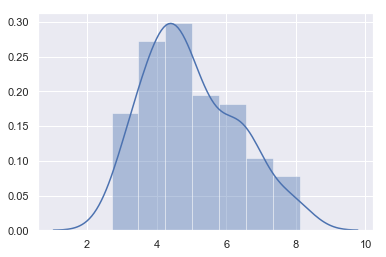

In [10]:
sns.distplot(rgb_rmses)

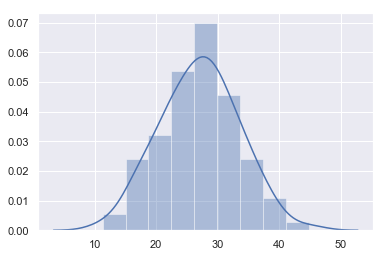

In [11]:
sns.distplot(rgb_delta_es)


If instead of RGB image we use XYZ image, the result would be as follows: 

In [12]:
xyz_rmses, xyz_delta_es = multi_run(method='xyz')
print('rmse mean is: ', np.mean(xyz_rmses), '\ndelta e mean is: ', np.mean(xyz_delta_es))

rmse mean is:  4.602233900581218 
delta e mean is:  25.72551887299319


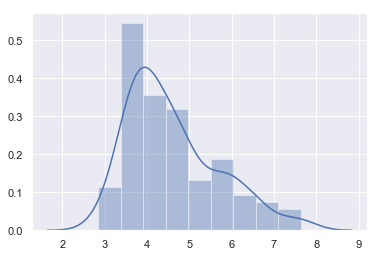

In [13]:
sns.distplot(xyz_rmses)

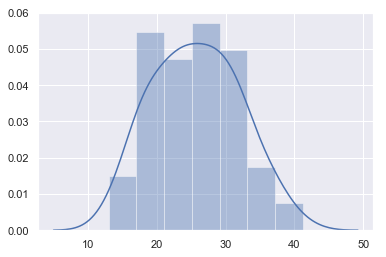

In [14]:
sns.distplot(xyz_delta_es)

Also, if instead of RGB image we use LAB image, the result would be as follows:

In [15]:
lab_rmses, lab_delta_es = multi_run(method='lab')
print('rmse mean is: ', np.mean(lab_rmses), '\ndelta e mean is: ', np.mean(lab_delta_es))

rmse mean is:  4.896718316677322 
delta e mean is:  26.329516030922168


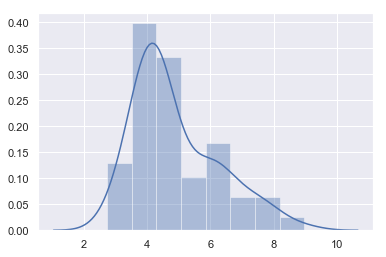

In [16]:
sns.distplot(lab_rmses)

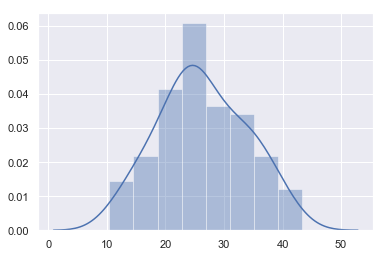

In [17]:
sns.distplot(lab_delta_es)

In [18]:
print('rgb mean rmses: ', np.mean(rgb_rmses), '\nxyz mean rmses: ', np.mean(xyz_rmses), 
      '\nlab mean rmses: ', np.mean(lab_rmses))

rgb mean rmses:  4.993698475728996 
xyz mean rmses:  4.602233900581218 
lab mean rmses:  4.896718316677322


In [19]:
print('rgb mean delta e: ', np.mean(rgb_delta_es), '\nxyz mean delta e: ', np.mean(xyz_delta_es), 
      '\nlab mean delta e: ', np.mean(lab_delta_es))

rgb mean delta e:  27.03465531086455 
xyz mean delta e:  25.72551887299319 
lab mean delta e:  26.329516030922168


So using XYZ images for training has the best error.